<a href="https://colab.research.google.com/github/amadousysada/cloud-big-data-pyspark/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Démarrage de la session Spark

In [222]:
# L'exécution de cette cellule démarre l'application Spark

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [ ]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1626050279029_0001,pyspark,idle,Link,Link,✔


# 2 Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

# 3 Import des librairies

In [232]:
import io
import os

import pandas as pd
import numpy as np
import tensorflow as tf

from PIL import Image

import matplotlib
from matplotlib import pyplot as plt


from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

import pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.functions import array_to_vector, vector_to_array
from pyspark.storagelevel import StorageLevel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline

print(f"Pyspark: {pyspark.__version__}")
print(f"Pyspark: {pyspark.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"PIL: {Image.__version__}")

Pyspark: 3.5.1
Pyspark: 3.5.1
Tensorflow: 2.19.0
Pandas: 2.2.2
Numpy: 2.0.2
Matplotlib: 3.10.0
PIL: 11.3.0


# 4 Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [236]:
PATH = spark.sparkContext.environment.get("DATA_PATH", "s3://p11_data")
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'

PATH:        s3://p11_data
PATH_Data:   s3://p11_data/Test
PATH_Result: s3://p11_data/Results


# 5 Traitement des données

## 5.1 Chargement des données

In [ ]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-data/Test...|2021-07-03 09:00:08|  7353|[FF D8 FF E0 00 1...|
|s3://p8-data/Test...|2021-07-03 09:00:08|  7350|[FF D8 FF E0 00 1...|
|s3://p8-data/Test...|2021-07-03 09:00:08|  7349|[FF D8 FF E0 00 1...|
|s3://p8-data/Test...|2021-07-03 09:00:08|  7348|[FF D8 FF E0 00 1...|
|s3://p8-data/Test...|2021-07-03 09:00:09|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [ ]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------+----------+
|path                                      |label     |
+------------------------------------------+----------+
|s3://p8-data/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://p8-data/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://p8-data/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://p8-data/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://p8-data/Test/Watermelon/r_95_100.jpg |Watermelon|
+------------------------------------------+----------+
only showing top 5 rows

None

## 5.2 Préparation du modèle

In [ ]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


14540800/14536120 [==============================] - 0s 0us/step

In [ ]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 5.3 Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

## 5.4 Exécutions des actions d'extractions de features

In [ ]:
features_df = images.repartition(24).select(col("path"), col("label"), featurize_udf("content").alias("features"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 5.4.1 Reduction de dimensions: PCA

In [ ]:
array_to_vector_udf = F.udf(array_to_vector, VectorUDT())
features_df = features_df.withColumn("features_input", array_to_vector_udf(features_df["features"]))

In [ ]:
%%time
row_1 = features_df.first()
num_features = len(row_1["features"])
print(f"Nombre de features : {num_features}")

Nombre de features : 1280
CPU times: user 11.7 ms, sys: 7.5 ms, total: 19.2 ms
Wall time: 34.7 s


> Normalisation

In [ ]:
%%time
scaler = StandardScaler(
    inputCol="features_input",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)
pca = PCA(
    k=num_features,
    inputCol=scaler.getOutputCol(),
    outputCol="pca_features"
)

pipeline = Pipeline(stages=[scaler , pca])

CPU times: user 1.73 ms, sys: 0 ns, total: 1.73 ms
Wall time: 7.07 ms


In [ ]:
%%time
model = pipeline.fit(features_df)

CPU times: user 198 ms, sys: 99.8 ms, total: 298 ms
Wall time: 9min 16s


In [ ]:
explained_variance = model.stages[-1].explainedVariance.toArray()
print("Variance expliquée par les composantes principales :")
print(explained_variance)

Variance expliquée par les composantes principales :
[1.31069782e-01 7.37034317e-02 5.90556065e-02 ... 5.92610008e-18
 3.31484959e-18 2.40315802e-18]


In [ ]:
explained_variance = model.stages[-1].explainedVariance
cumulative_variance = np.cumsum(explained_variance)

df_results = pd.DataFrame({
    'Dimension': ["Dim" + str(i+1) for i in range(len(explained_variance))],
    'Variance Expliquée (%)': explained_variance * 100,
    'Somme Cumulée (%)': cumulative_variance * 100
})

df_results

,Dimension,Variance Expliquée (%),Somme Cumulée (%)
0,Dim1,1.310698e+01,13.106978
1,Dim2,7.370343e+00,20.477321
2,Dim3,5.905561e+00,26.382882
3,Dim4,4.859749e+00,31.242631
4,Dim5,4.657196e+00,35.899827
...,...,...,...
1275,Dim1276,8.757577e-16,100.000000
1276,Dim1277,7.266097e-16,100.000000
1277,Dim1278,5.926100e-16,100.000000
1278,Dim1279,3.314850e-16,100.000000


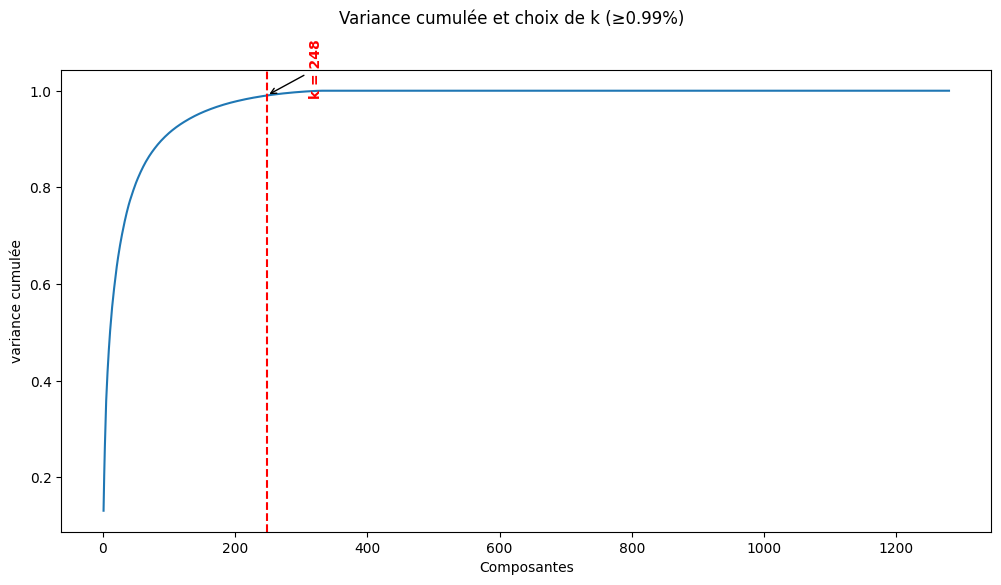

In [ ]:
target = 0.99
n = len(cumulative_variance)
x = np.arange(1, n + 1)
k = np.searchsorted(cumulative_variance, target) + 1

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, cumulative_variance)
ax.axvline(x=k, linestyle='--', color="red")
#ax.axhline(y=target, linestyle=':')

ax.set_xlabel("Composantes")
ax.set_ylabel("variance cumulée")

ax.annotate(
    f"k = {k}",
    xy=(k, cumulative_variance[k-1]),
    xytext=(k + n*0.05, target),
    arrowprops=dict(arrowstyle="->"),
    rotation=90,
    color="red",
    fontweight="bold"
)
plt.suptitle(f"Variance cumulée et choix de k (≥{target}%)")
plt.show()

In [ ]:
print(f"Avec {k} dimensions nous capturons {target} de la variance")

Avec 248 dimensions nous capturons 0.99 de la variance


In [ ]:
pca = PCA(
    k=k,
    inputCol=scaler.getOutputCol(),
    outputCol="pca_features"
)

pipeline = Pipeline(stages=[scaler , pca])

In [ ]:
%%time
model = pipeline.fit(features_df)

CPU times: user 161 ms, sys: 107 ms, total: 268 ms
Wall time: 8min 25s


In [ ]:
features_df = model.transform(features_df)

### 5.4.2 Enregistrement des données traitées au format "**parquet**"

In [ ]:
%%time
features_df = features_df.withColumn("pca_features", vector_to_array(features_df["pca_features"]))
features_df.drop('scaled_features', 'features_input').write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 6 Chargement des données enregistrées et validation du résultat

In [ ]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                           path  ...                                           features
0    s3://p8-data/Test/Watermelon/r_174_100.jpg  ...  [0.0059991637, 0.44703647, 0.0, 0.0, 3.3713572...
1  s3://p8-data/Test/Pineapple Mini/128_100.jpg  ...  [0.0146466885, 4.080593, 0.055877004, 0.0, 0.0...
2  s3://p8-data/Test/Pineapple Mini/137_100.jpg  ...  [0.0, 4.9659867, 0.0, 0.0, 0.0, 0.0, 0.5144821...
3      s3://p8-data/Test/Watermelon/275_100.jpg  ...  [0.22511952, 0.07235509, 0.0, 0.0, 1.690149, 0...
4      s3://p8-data/Test/Watermelon/271_100.jpg  ...  [0.3286234, 0.18830013, 0.0, 0.0, 1.9123534, 0...

[5 rows x 3 columns]

In [ ]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [ ]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22688, 3)